# Oracle

Oracle $x->f(x)$

Boolean Oracle 

$$U_f |x,0> = |x, f(x)>$$

where x is a register of qubits which encode in x the binary value of inputs.
There are as many qubits as needed for the binary encoding
Same idea for the second register 0, which means that every qubit starts
in a 0 state and then turns into the binary encoding of f(x)

Phase Oracle

$$P_f |x> = (-1)^{f(x)} |x>$$

where x can be a multi-qubit register and f(x) is typically 0 or 1. It can be turned into a 
multi qubit gate just applying this gate to every qubit and considering each bit

# Taking out the garbage

To implement an Oracle in a quantum circuit we must use quantum gates 
that mimics the function in the same way it works in a classical circuit.
We cannot, though, simply take the classical circuit and replace the classical gates
with their quantum counterparts.

One issue is reversibility, i.e. we need reversible unitary gates but classical gates are usually not reversible. For example, an oracle $U_f = \sum_x |f(x)><x|$ would not be reversible, which is why
we used the Boolean oracle with the form as before

$$U_f |x, 0> = |x, f(x)>$$

Since it includes a copy of x in the output, it is reversible even when 
f(x) is not.

Another issue is to take care of superposition in the correct way. Garbage left out from computations in classical circuits can be easily
deleted by resetting the bits in excess, but this may lead to consequences in a quantum algorithm due to entanglement.

For example consider the unitary gate

$$V_f |x,0,0> = |x, f(x), g(x)>$$

where g(x) is garbage information left over.


Suppose we have state $\sum_x |x, f(x)>$ and need to recover intial state 
$\sum_x |x, 0>$, we need just to apply $U^{\dagger}_f$. However, if we can only apply $V_f^{\dagger}$, the operation won't have the same effect due to g(x), even though on input and output register the $V_f$ operation does exactly the same as $U_f$.

Explicit example: x,f and g all take one single qubit, f(x)=x and g(x)=x, which
    can be achieved with a single CNOT gate controlled on x, the input register.

The implementation for $U_f$ is just:

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute

In [3]:
input_bit = QuantumRegister(1, 'input')
output_bit = QuantumRegister(1, 'output')
garbage_bit = QuantumRegister(1, 'garbage')

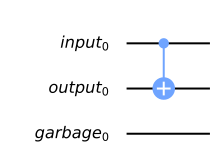

In [12]:
Uf = QuantumCircuit(input_bit, output_bit, garbage_bit)
Uf.cx(input_bit[0], output_bit[0])
Uf.draw(output='mpl', justify='none')

For $V_f$ we need also a CNOT on the garbage, in order to copy the control
bit.

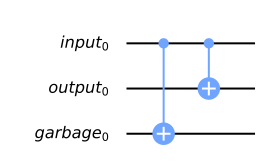

In [11]:
Vf = QuantumCircuit(input_bit, output_bit, garbage_bit)
Vf.cx(input_bit[0], garbage_bit[0])
Vf.cx(input_bit[0], output_bit[0])
Vf.draw(output='mpl', justify='none')

Effect of $U_f \cdot V_f^{\dagger}$

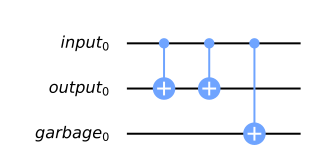

In [6]:
qc = Uf + Vf.inverse()
qc.draw(output='mpl', justify='none')

$CNOT^2 = 1$, so it remains only the last CNOT, i.e.

$$
V_f^\dagger U_f |x,0,0> = V_f^\dagger |x,f(x),0> = |x,0,g(x)
$$


So the effect of this is to return the state we want, but it's entangled with 
garbage we don't need. In particular the final state will be

$$\sum_{x \in \{0,1\}} |x, 0, g(x)>$$

i.e. the input qubit is now entangled to the garbage qubit.

We need a way to remove classical garbage from our states.

Uncomputation: we take another (fourth in our case when everything needs one qubit) qubit, and apply $V_f$

$$V_f |x,0,0,0> -> |x,f(x),g(x)>$$

and then we can use a series of CNOT gates to copy f(x) to the fourth register, i.e. one CNOT gate for each qubit used to encode f(x) and targeted at the corresponding qubit of the fourth register.

For one qubit in our example, it is like this

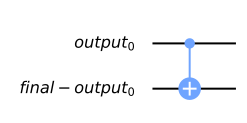

In [13]:
final_output_bit = QuantumRegister(1, 'final-output')

copy = QuantumCircuit(output_bit, final_output_bit)
copy.cx(output_bit, final_output_bit)

copy.draw()

The effect is to copy the f(x) to the fourth register

$$|x, f(x), g(x), f(x)>$$

Finally apply $V_f^\dagger$ to this state, so as to undo the original computation

$$V_f^\dagger \otimes 1_2 |x,f(x),g(x),f(x)> = |x,0,0,f(x)>$$

Thus, we have used $V_f$ and CNOT and achieved an effect similar to that
of $U_f$.

For our single qubit registers example, the whole process is

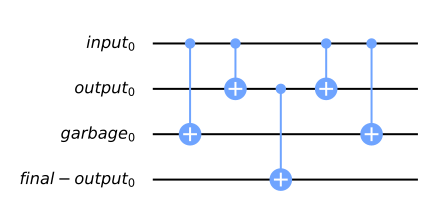

In [14]:
Uf_new = Vf + copy + Vf.inverse()

Uf_new.draw(output='mpl', justify='none')

and it can be inverted to have $U^\dagger_f$

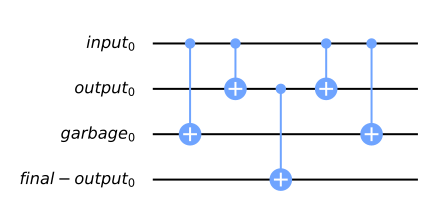

In [16]:
Uf_new.inverse().draw(output='mpl', justify='none')

And in this case we can see that if we apply $U_f$ between the correct qubits

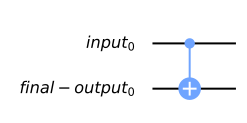

In [17]:
Uf = QuantumCircuit(input_bit, final_output_bit)
Uf.cx(input_bit[0], final_output_bit[0])
Uf.draw(output='mpl', justify='none')

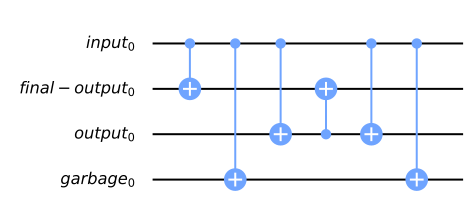

In [18]:
qc = Uf + Uf_new.inverse()
qc.draw(output='mpl', justify='none')

Exercises:

1. The circuit correctly gives the $U_f$ computation on the final-output register

2. Each CNOT gate with a target qubit in $|1>$ negates the control qubit, instead of just copying it. Same for the CNOT between output and final-output, so this means that if both 'o' and 'fo' qubit are $|1>$ the input is negate twice and thus gives the correct result on 'fo'. If only one of the two is initialized as $|1>$, the input is negated in 'fo'. 